In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from cmcrameri import cm
import datetime
from scipy.signal import savgol_filter
os.chdir('/users/marianne/documents/pe_snow_fires/ICB')
fig_dir = '/users/marianne/documents/pe_snow_fires/ICB/'

In [3]:
def add_datetime(hobo,station):
    kh = hobo.keys()
    hobo['dt']=pd.to_datetime(hobo[kh[1]])
    station['dt'] = pd.to_datetime(station['TIMESTAMP'])

In [4]:
## read in all data
hoboA = pd.read_csv('hoboA1.csv',header=1)
hoboB = pd.read_csv('hoboB1.csv',header=1)
hoboC = pd.read_csv('hoboC1.csv',header=1)
stationA = pd.read_csv('TableA1.csv',header=0)
stationB = pd.read_csv('TableB1.csv',header=0)
stationC = pd.read_csv('TableC1.csv',header=0)

cameraA = pd.read_csv('snow_summary_A.csv',header=2)
cameraB = pd.read_csv('snow_summary_B.csv',header=2)
cameraC = pd.read_csv('snow_summary_C.csv',header=2)

add_datetime(hoboA,stationA)
add_datetime(hoboB,stationB)
add_datetime(hoboC,stationC)

C:\Users\Marianne\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1,2,4,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Marianne\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1,2,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
def resample_prep(hobo,station,camera):
    kh = hobo.keys()
    ks = station.keys()
    idx_s = [6,7,8,9,10,11,13,14,16,17,18,19,20,21,22,23,24,25,26]
    hobo.index = hobo['dt']
    station.index = station['dt']
    index_hr = hobo[kh[6]].resample('1H').bfill().index
    index_day = hobo[kh[6]].resample('24H').bfill().index
    hourly = pd.DataFrame(index=index_hr)
    daily = pd.DataFrame(index = index_day)
    for k in kh[2:4]:
        tmp = pd.Series(hobo[k])
        tmp.index = hobo['dt']
        tmp_hourly = tmp.resample('1H').interpolate()
        if k==kh[2]:  
            tmp_c = (tmp_hourly-32) * 5/9
            tmp_c.name = 'tempC'
            hourly = hourly.join(pd.DataFrame(tmp_c))
        hourly = hourly.join(pd.DataFrame(tmp_hourly))

    for k in ks[idx_s]:
        tmp = pd.Series(station[k].astype('float'))
        tmp.index = station['dt']
        try:
            idx = tmp.index[np.where(tmp.index.duplicated())[0][0]]
            tmp = tmp.drop(idx)
        except:
            continue
        tmp_hourly = tmp.resample('1H').interpolate() # bfill()
        hourly = hourly.join(pd.DataFrame(tmp_hourly))


    for k in kh[2:4]:
        tmp = pd.Series(hobo[k])
        tmp.index = hobo['dt']
        tmp_daily = tmp.resample('24H').mean()
        if k==kh[2]:  
            tmp_c = (tmp_daily-32) * 5/9
            tmp_c.name = 'tempC'
            daily = daily.join(pd.DataFrame(tmp_c))
        daily = daily.join(pd.DataFrame(tmp_daily))

    for k in ks[idx_s]:
        tmp = pd.Series(station[k].astype('float'))
        tmp.index = station['dt']
        idx = np.nan
        try:
            idx = tmp.index[np.where(tmp.index.duplicated())[0][0]]
            tmp = tmp.drop(idx)
        except:
            continue
        tmp_daily = tmp.resample('24H').mean()
        daily = daily.join(pd.DataFrame(tmp_daily))

    camera['dt'] = pd.to_datetime(camera['Date'])
    camera_wy20 = camera[camera['dt']>hobo['dt'][0]]
    camera_wy20.index = camera_wy20['dt']
    
    return hourly, daily, camera_wy20

In [6]:
hobo = hoboA
station = stationA
idx_s = [6,7,8,9,10,11,13,14,16,17,18,19,20,21,22,23,24,25,26]
kh = hobo.keys()
ks = station.keys()
hobo.index = hobo['dt']
station.index = station['dt']
index_hr = hobo[kh[6]].resample('1H').bfill().index
index_day = hobo[kh[6]].resample('24H').bfill().index
hourly = pd.DataFrame(index=index_hr)
daily = pd.DataFrame(index = index_day)
for k in kh[2:4]:
    tmp = pd.Series(hobo[k]).astype('float')
    tmp.index = hobo['dt']
    tmp_hourly = tmp.resample('1H').bfill()
    print(k)
    if k=='Temp, °F (LGR S/N: 20947454, SEN S/N: 20947454)':  
        tmp_c = (tmp_hourly-32) * 5/9
        tmp_c.name = 'tempc'
        hourly = hourly.join(pd.DataFrame(tmp_c))
    hourly = hourly.join(pd.DataFrame(tmp_hourly))
for k in ks[idx_s]:
    tmp = pd.Series(station[k]).astype('float')
    tmp.index = station['dt']
    try:
        idx = tmp.index[np.where(tmp.index.duplicated())[0][0]]
        tmp = tmp.drop(idx)
    except:
        continue
    tmp_hourly = tmp.resample('1H').mean() # bfill()
    # tmp_hourly.column = k
    hourly = hourly.join(pd.DataFrame(tmp_hourly))

Temp, °F (LGR S/N: 20947454, SEN S/N: 20947454)
Intensity, lum/ft² (LGR S/N: 20947454, SEN S/N: 20947454)


In [7]:
hourlyA, dailyA, cameraA = resample_prep(hoboA, stationA, cameraA)
hourlyB, dailyB, cameraB = resample_prep(hoboB, stationB, cameraB)
hourlyC, dailyC, cameraC = resample_prep(hoboC, stationC, cameraC)


In [13]:
kh[1]

'Temp, °F (LGR S/N: 20947447, SEN S/N: 20947447)'

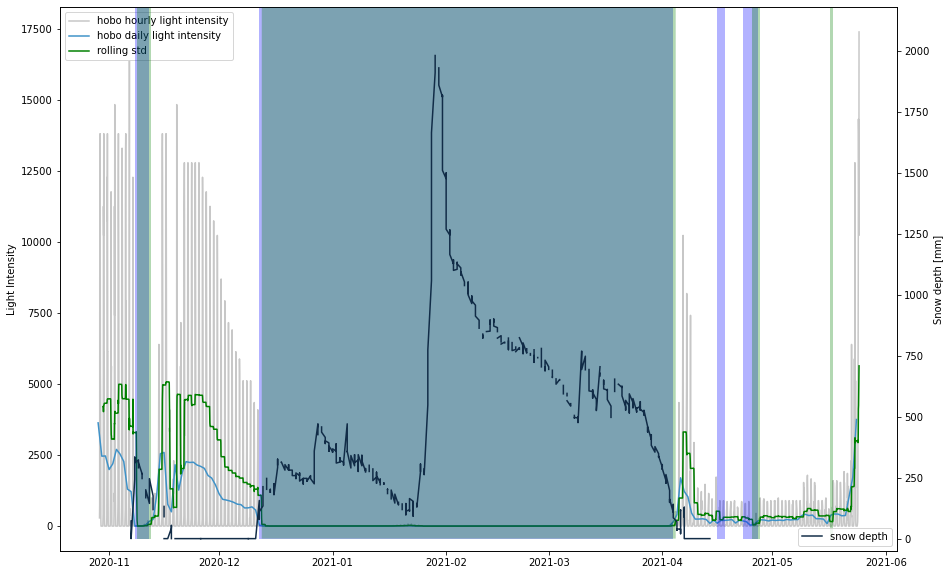

In [15]:
hourly, daily, camera, fig_name = hourlyB, dailyB, cameraB, 'snow_light_B.jpg'
kh = hourly.keys()
cols = cm.bukavu(np.linspace(0,1,5))

y = hourly[kh[2]].astype('float')
x = hourly.index

y2 = daily[kh[2]]
x2 = daily.index

smooth = savgol_filter(y, window_length = 25, polyorder = 1)
smooth = savgol_filter(smooth, window_length = 11, polyorder = 1)
fig,ax=plt.subplots(figsize=(15,10))
ax2=ax.twinx()
ax.plot(x,y,color=cm.grayC(50),label='hobo hourly light intensity')
ax.plot(x2,y2,color=cols[1],label='hobo daily light intensity')
ax2.fill_between(x2,0,2500,where=y2<200,facecolor='blue',alpha=0.3)
ax2.set_ylim(-50,1.1*np.nanmax(camera['Snow Depth (mm)']))
# y.rolling(window=24).mean().plot(style='k', ax=ax, label='rolling mean')
y_std = y.rolling(window=24).std()# .plot(style='g', ax=ax, label='rolling std')
ax.plot(y_std,color='g',label='rolling std')
ax2.fill_between(y_std.index,0,2500,where=y_std<200,facecolor='green',alpha=0.3)
ax2.plot(camera['Snow Depth (mm)'],'-',color=cm.oslo(50),label='snow depth')
ax.set_ylabel('Light Intensity')
ax2.set_ylabel('Snow depth [mm]')
ax.legend()
ax2.legend(loc = 'lower right')
plt.show()
# fig.savefig(fig_dir + fig_name)

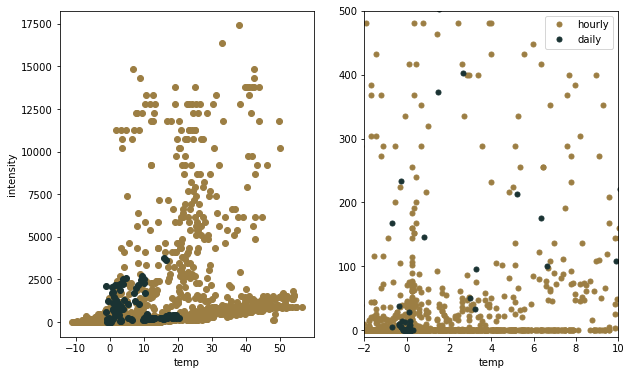

In [9]:
hourly = hourlyB
daily = dailyB
figname = 'temp_intensity_B.jpg'

fig,ax=plt.subplots(1,2,figsize=(10,6))
ax[0].plot(hourly['tempC'],hourly[hourly.keys()[2]],'o',label='hourly',color=cols[3])
ax[0].plot(daily['tempC'],daily[daily.keys()[2]],'o',label='daily',color=cols[0])

ax[1].plot(hourly['tempC'],hourly[hourly.keys()[2]],'o',markersize=5,label='hourly',color=cols[3])
ax[1].plot(daily['tempC'],daily[daily.keys()[2]],'o',markersize=5,label='daily',color=cols[0])
ax[1].set_ylim(-10,500)
ax[1].set_xlim(-2,10)
ax[0].set_xlabel('temp')
ax[1].set_xlabel('temp')
ax[0].set_ylabel('intensity')
plt.legend()
# plt.savefig(figname)

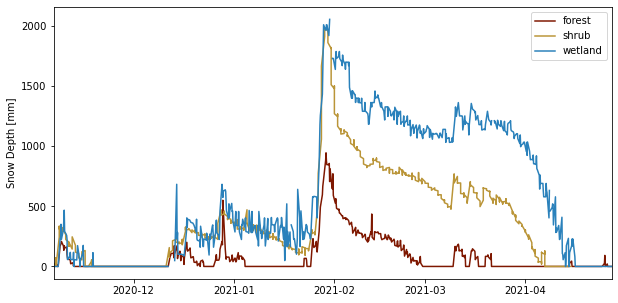

In [10]:
cols = cm.roma(np.linspace(0,1,12))
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(cameraA['Snow depth gap-filled'],label ='forest',color=cols[0])
ax.plot(cameraB['Snow depth gap-filled'],label = 'shrub',color=cols[3])
ax.plot(cameraC['Snow depth gap-filled'], label='wetland',color=cols[9])
ax.set_xlim(cameraA.index[0],cameraA.index[-1])
ax.set_ylabel('Snow Depth [mm]')
plt.legend()
plt.show()
# fig.savefig('snow_depth_cameras.png')

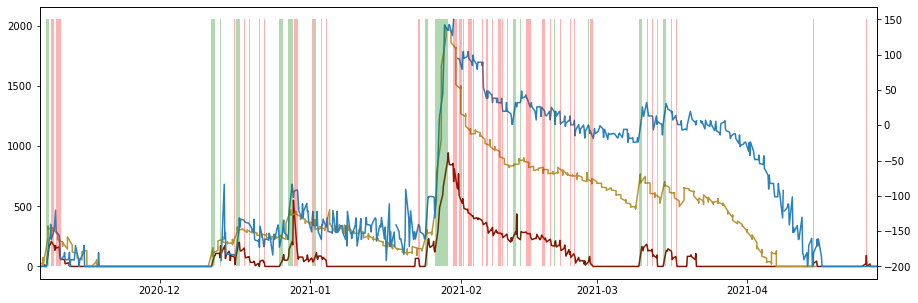

In [39]:
dataA = cameraA['Snow depth gap-filled']
dataB = cameraB['Snow depth gap-filled']
dataC = cameraC['Snow depth gap-filled']
cols = cm.roma(np.linspace(0,1,12))

deriv = pd.Series(data = np.gradient(dataA), index=dataA.index)
fig,ax=plt.subplots(figsize=(15,5))
ax2=ax.twinx()
ax.plot(dataA, color=cols[0])
ax.plot(dataB,color=cols[3])
ax.plot(dataC,color=cols[9])
ax.plot()
# ax2.plot(deriv,color='k')
ax2.fill_between(deriv.index,-200,150,where=deriv>10,facecolor='green',alpha=0.3)
ax2.fill_between(deriv.index,-200,150,where=deriv<-5,facecolor='red',alpha=0.3)

ax.set_xlim(cameraA.index[0],cameraA.index[-1])

plt.show()

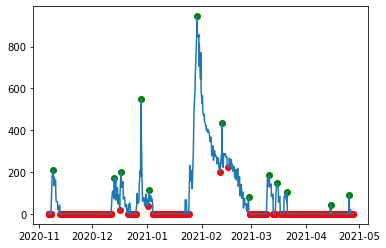

In [79]:
from scipy.signal import argrelextrema
n = 10

df = pd.DataFrame(data = dataA)

df['min'] = df.iloc[argrelextrema(df.data.values, np.less_equal,
                    order=n)[0]]['data']
df['max'] = df.iloc[argrelextrema(df.data.values, np.greater_equal,
                    order=n)[0]]['data']
df['max'] = df['max'].where(df.data.values > 1)

locals_list = []
for i in range(len(df['max'])):
    val = 0
    if ~np.isnan(df['max'][i]):
        val = 1
    elif ~np.isnan(df['min'][i]):
        val = -1
    locals_list.append(val)
df['locals'] = locals_list

for i in range(len(df['locals'])):
    if df['locals'][i] == 0:
        rest = df['locals'][i:-1]
        idxs = np.where(rest!=0)   

plt.scatter(df.index, df['min'], c='r')
plt.scatter(df.index, df['max'], c='g')
plt.plot(df.index, df['data'])
plt.show()


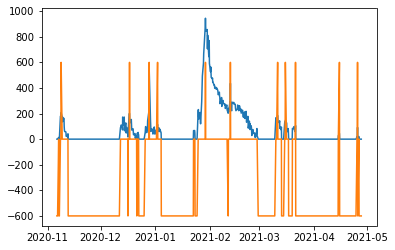

In [75]:

plt.plot(df.index, df['data'])

plt.plot(df['locals']*600)

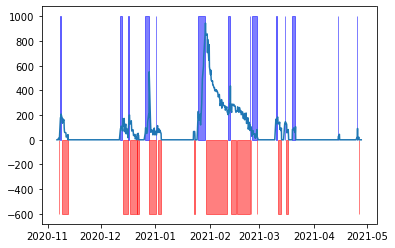

In [81]:
melt_list = []
for i in range(len(df['locals'])):
    val = np.nan
    if df['locals'][i] == 0:
        rest = df['locals'][i:-1]
        idxs = np.where(rest!=0)
        idx = idxs[0][0]
        test = rest[idx]
        if test == 1:
            if (df['data'][idx+i]<df['data'][i]):
                val = -1
            else:
                val = 1
        elif test ==-1:
            val = -1
    melt_list.append(val)

df['melt'] = melt_list


plt.plot(df.index, df['data'])
#plt.plot(df['locals']*600)
# plt.plot(df['melt']*600,'o')
plt.fill_between(df.index,0,1000,df['melt']==1,color='blue',alpha = 0.5)
plt.fill_between(df.index,0,-600,df['melt']==-1,color='red',alpha = 0.5)

In [132]:
# changes = pd.DataFrame(data=[],columns = ['start','end','change'])
changes = []
for i in range(len(df['max'])):
    val = np.nan
    if df['max'][i] > 0:
        max_val = df['max'][i]
        prev = df['min'][0:i]
        idxs = np.where(~np.isnan(prev))
        idx = idxs[0][0]
        min_val = df['min'][idx]
        change = max_val-min_val
        start_date = df.index[i+idx]
        end_date = df.index[i]
        changes.append([start_date,end_date,change])
        rest = df['min'][i:-1]
        idxs = np.where(~np.isnan(rest))
        idx = idxs[0][0]
        min_val = df['min'][i+idx]
        change = min_val-max_val
        start_date = df.index[i]
        end_date = df.index[i+idx]
        changes.append([start_date,end_date,change])


In [133]:
changes_df = pd.DataFrame(changes,columns = ['start','end','change'])

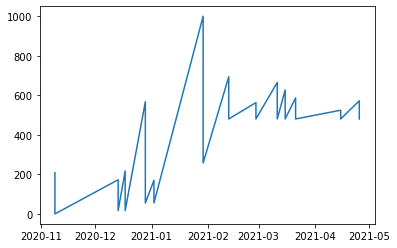

In [134]:
plt.plot(changes_df['start'],np.cumsum(changes_df['change']))

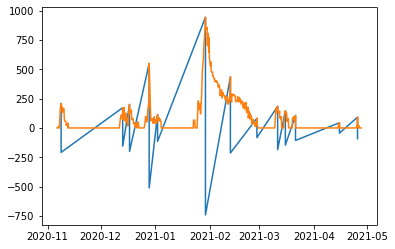

In [136]:
# plt.plot(np.cumsum(changes_df['change']))
plt.plot(changes_df['start'], changes_df['change'],'-')
# plt.plot(range(len(df['data'])),df['data'])
plt.plot(df['data'])